In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import sys, importlib
PROJECT_ROOT = "/content/drive/MyDrive/SA_CropType_SourceCoop"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import common
importlib.reload(common)
from common import *

ensure_dirs()

print("✅ BASE_DIR:", BASE_DIR)
print("✅ FIELD_INFO_TRAIN:", FIELD_INFO_TRAIN, "exists:", FIELD_INFO_TRAIN.exists())
print("✅ LABELS_DIR:", LABELS_DIR, "exists:", LABELS_DIR.exists())
print("✅ S2_DIR:", S2_DIR, "exists:", S2_DIR.exists())
print("✅ S1_DIR:", S1_DIR, "exists:", S1_DIR.exists())
print("✅ OUT_DIR:", OUT_DIR, "exists:", OUT_DIR.exists())
print("✅ TFC_FILE:", TFC_FILE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ BASE_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop
✅ FIELD_INFO_TRAIN: /content/drive/MyDrive/SA_CropType_SourceCoop/field_info_train.csv exists: True
✅ LABELS_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/train/labels exists: True
✅ S2_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/train/imagery/s2 exists: True
✅ S1_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/train/imagery/s1 exists: True
✅ OUT_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs exists: True
✅ TFC_FILE: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/tile_field_crop_table.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os, json
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt

# === BASE ===
BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")

# === TRAIN PATHS ===
TRAIN_DIR   = BASE_DIR / "train"
LABELS_DIR  = TRAIN_DIR / "labels"
S2_DIR      = TRAIN_DIR / "imagery" / "s2"
S1_DIR      = TRAIN_DIR / "imagery" / "s1"

CSV_PATH    = BASE_DIR / "field_info_train.csv"

# === OUTPUTS ===
OUTPUT_DIR  = BASE_DIR / "outputs"
META_DIR    = OUTPUT_DIR / "meta"
FIG_DIR     = OUTPUT_DIR / "figures"
TAB_DIR     = OUTPUT_DIR / "tables"

for d in [OUTPUT_DIR, META_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("CSV_PATH exists:", CSV_PATH.exists())
print("LABELS_DIR exists:", LABELS_DIR.exists())
print("S2_DIR exists:", S2_DIR.exists())
print("S1_DIR exists:", S1_DIR.exists())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop
CSV_PATH exists: True
LABELS_DIR exists: True
S2_DIR exists: True
S1_DIR exists: True


In [ ]:
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# Kolon isimlerini normalize edip kolay yakalayalım
cols_lower = {c.lower(): c for c in df.columns}

# field id kolonu
if "field_id" in cols_lower:
    field_id_col = cols_lower["field_id"]
elif "field id" in cols_lower:
    field_id_col = cols_lower["field id"]
elif "fieldid" in cols_lower:
    field_id_col = cols_lower["fieldid"]
else:
    raise ValueError(f"Field ID kolonu bulunamadı. Mevcut kolonlar: {df.columns.tolist()}")

# crop kolonu
if "crop" in cols_lower:
    crop_col = cols_lower["crop"]
elif "crop_id" in cols_lower:
    crop_col = cols_lower["crop_id"]
elif "crop id" in cols_lower:
    crop_col = cols_lower["crop id"]
else:
    raise ValueError(f"Crop kolonu bulunamadı. Mevcut kolonlar: {df.columns.tolist()}")

# İsimleri standartla
df = df.rename(columns={field_id_col: "field_id", crop_col: "crop"})
field_id_col, crop_col = "field_id", "crop"

# Tip düzeltmeleri
df["field_id"] = pd.to_numeric(df["field_id"], errors="coerce").astype("Int64")
df["crop"] = df["crop"].astype(str)

print("OK -> kolonlar:", df.columns.tolist())
print("Toplam satır:", len(df))
print("Unique field:", df["field_id"].nunique())
print("Unique crop:", df["crop"].nunique())
df.head()

OK -> kolonlar: ['field_id', 'crop']
Toplam satır: 87113
Unique field: 87113
Unique crop: 9


,field_id,crop
0,84337,Fallow
1,91979,Weeds
2,119964,Weeds
3,43134,Weeds
4,95735,Fallow


In [ ]:
label_tifs = sorted(LABELS_DIR.glob("*_field_ids.tif"))
print("Label tif sayısı:", len(label_tifs))
print("Örnek:", [p.name for p in label_tifs[:5]])

# tile_id örnekleri
tile_ids = [p.name.replace("_field_ids.tif","") for p in label_tifs]
print("İlk 10 tile:", tile_ids[:10])

Label tif sayısı: 499
Örnek: ['1000_field_ids.tif', '1001_field_ids.tif', '1002_field_ids.tif', '1003_field_ids.tif', '1004_field_ids.tif']
İlk 10 tile: ['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009']


In [ ]:
tile_to_fields = {}
field_to_tiles = {}

for fp in tqdm(label_tifs, desc="Reading label tifs"):
    tile_id = fp.name.replace("_field_ids.tif","")
    with rasterio.open(fp) as src:
        arr = src.read(1)

    u = np.unique(arr)
    u = u[u > 0].astype(np.int64)  # 0 = nodata/arka plan

    fields = u.tolist()
    tile_to_fields[tile_id] = fields

    for fid in fields:
        field_to_tiles.setdefault(int(fid), []).append(tile_id)

# Kaydet
with open(META_DIR / "tile_to_fields.json", "w") as f:
    json.dump(tile_to_fields, f)

with open(META_DIR / "field_to_tiles.json", "w") as f:
    json.dump({str(k): v for k, v in field_to_tiles.items()}, f)

print("Kaydedildi:", META_DIR / "tile_to_fields.json")
print("Kaydedildi:", META_DIR / "field_to_tiles.json")
print("Örnek tile->fields:", list(tile_to_fields.items())[:1])

Reading label tifs: 100%|██████████| 499/499 [00:38<00:00, 12.90it/s]


Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/tile_to_fields.json
Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/field_to_tiles.json
Örnek tile->fields: [('1000', [10697, 14604, 17138, 22246, 25176, 25728, 28779, 31058, 33569, 37094, 47262, 48198, 50257, 62999, 64180, 75988, 83081, 89239, 90842, 94195, 107554, 110246])]


In [ ]:
# CSV'den field->crop lookup
field_to_crop = df.drop_duplicates("field_id").set_index("field_id")["crop"].to_dict()

rows = []
missing_crop = 0

for tile_id, fields in tile_to_fields.items():
    for fid in fields:
        crop = field_to_crop.get(int(fid), "UNK")
        if crop == "UNK":
            missing_crop += 1
        rows.append((tile_id, int(fid), crop))

tfc = pd.DataFrame(rows, columns=["tile_id", "field_id", "crop"])

tfc_path = META_DIR / "tile_field_crop_table.csv"
tfc.to_csv(tfc_path, index=False)

print("Tablo satır:", len(tfc))
print("UNK crop sayısı:", missing_crop)
print("Kaydedildi:", tfc_path)
tfc.head()

Tablo satır: 16893
UNK crop sayısı: 0
Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/tile_field_crop_table.csv


,tile_id,field_id,crop
0,1000,10697,Weeds
1,1000,14604,Lucerne/Medics
2,1000,17138,Fallow
3,1000,22246,Lucerne/Medics
4,1000,25176,Fallow


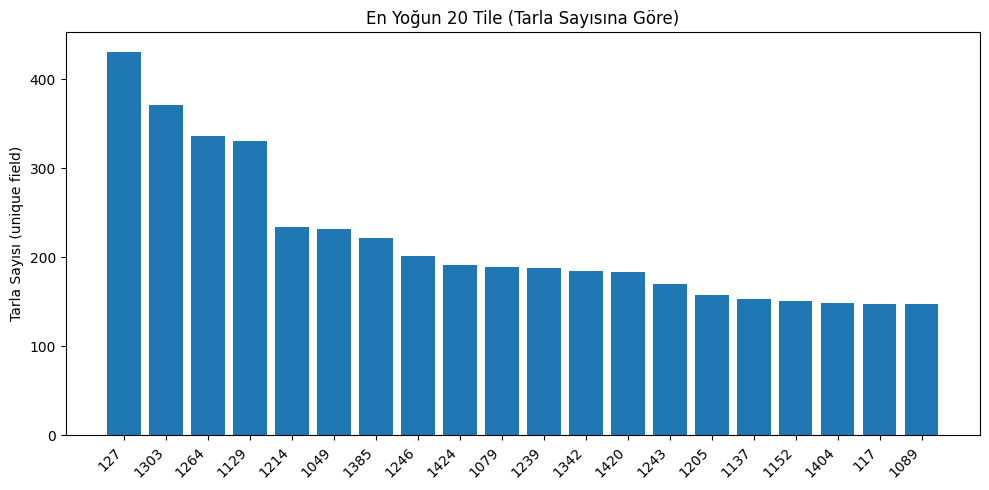

Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/tables/tiles_field_counts.csv ve /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/top_tiles_by_field_count.png


In [ ]:
# Tile başına tarla sayısı
tiles_field_counts = (
    tfc.groupby("tile_id")["field_id"].nunique()
       .reset_index(name="n_fields")
       .sort_values("n_fields", ascending=False)
)
tiles_field_counts.to_csv(TAB_DIR / "tiles_field_counts.csv", index=False)

top20 = tiles_field_counts.head(20)

plt.figure(figsize=(10,5))
plt.bar(top20["tile_id"].astype(str), top20["n_fields"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Tarla Sayısı (unique field)")
plt.title("En Yoğun 20 Tile (Tarla Sayısına Göre)")
plt.tight_layout()
plt.savefig(FIG_DIR / "top_tiles_by_field_count.png", dpi=200)
plt.show()

print("Kaydedildi:",
      TAB_DIR / "tiles_field_counts.csv",
      "ve", FIG_DIR / "top_tiles_by_field_count.png")


In [ ]:
target_crops = ["Wine grapes", "Planted pastures (perennial)", "Wheat", "Lucerne/Medics"]

tfc_target = tfc[tfc["crop"].isin(target_crops)].copy()

need_tiles = sorted(tfc_target["tile_id"].unique().tolist())
need_fields = sorted(tfc_target["field_id"].unique().tolist())

print("Hedef sınıflar:", target_crops)
print("Gerekli tile sayısı:", len(need_tiles))
print("Gerekli field sayısı:", len(need_fields))

pd.DataFrame({"tile_id": need_tiles}).to_csv(TAB_DIR / "tiles_for_top4.csv", index=False)
pd.DataFrame({"field_id": need_fields}).to_csv(TAB_DIR / "fields_for_top4.csv", index=False)

print("Kaydedildi:", TAB_DIR / "tiles_for_top4.csv")
print("Kaydedildi:", TAB_DIR / "fields_for_top4.csv")

Hedef sınıflar: ['Wine grapes', 'Planted pastures (perennial)', 'Wheat', 'Lucerne/Medics']
Gerekli tile sayısı: 377
Gerekli field sayısı: 11227
Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/tables/tiles_for_top4.csv
Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/tables/fields_for_top4.csv


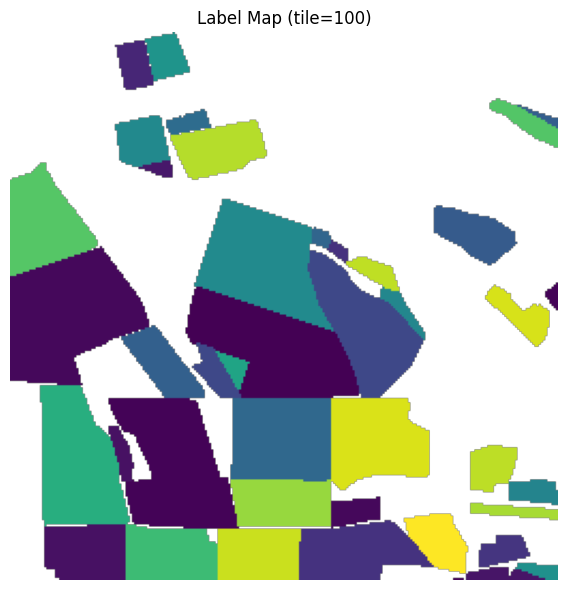

Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/label_map_tile_100.png


In [ ]:
# Örnek tile seç
sample_tile = need_tiles[0] if len(need_tiles) > 0 else tile_ids[0]
fp = LABELS_DIR / f"{sample_tile}_field_ids.tif"

with rasterio.open(fp) as src:
    arr = src.read(1)

# sadece >0 olanları göstereceğiz
mask = arr > 0

plt.figure(figsize=(6,6))
plt.imshow(np.where(mask, arr, np.nan))
plt.title(f"Label Map (tile={sample_tile})")
plt.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR / f"label_map_tile_{sample_tile}.png", dpi=200)
plt.show()

print("Kaydedildi:", FIG_DIR / f"label_map_tile_{sample_tile}.png")

Label tif: /content/drive/MyDrive/SA_CropType_SourceCoop/train/labels/100_field_ids.tif
✅ Tile=100 | Toplam field sayısı: 42
Seçilen (en büyük) field id'ler: [3475, 727, 1784, 59060, 76751, 41625, 27003, 115563, 90377, 18469, 83918, 103706, 6412, 112660, 108855]


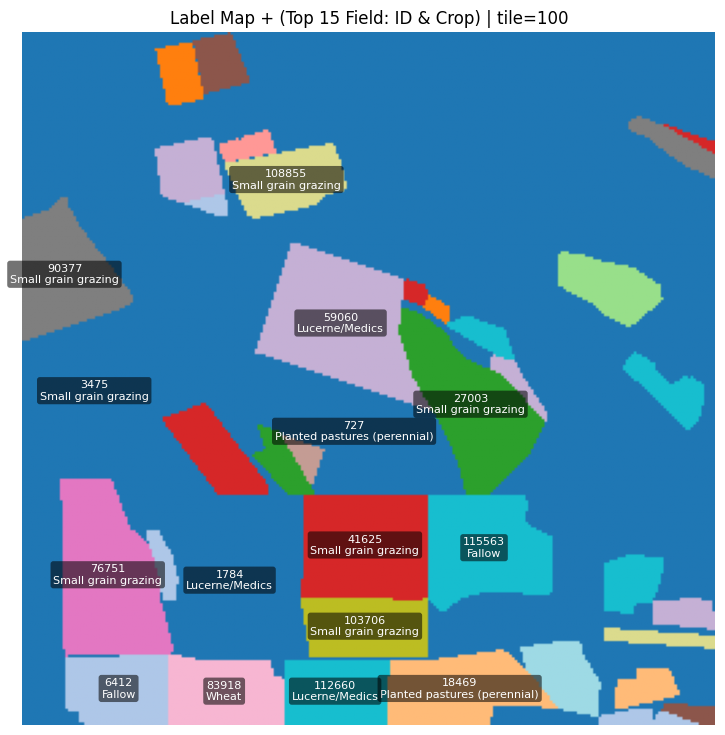

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# ----------------------------
# 0) Gerekli path'ler (seninkiler)
# ----------------------------
# Bu değişkenler sende zaten var demiştin:
# BASE_DIR, TRAIN_DIR, LABELS_DIR, CSV_PATH
# Eğer yoksa örnek:
# from pathlib import Path
# BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
# TRAIN_DIR = BASE_DIR / "train"
# LABELS_DIR = TRAIN_DIR / "labels"
# CSV_PATH = BASE_DIR / "field_info_train.csv"

sample_tile = "100"  # istediğin tile id (string)

label_tif = LABELS_DIR / f"{sample_tile}_field_ids.tif"
print("Label tif:", label_tif)
assert label_tif.exists(), f"Bulunamadı: {label_tif}"

# ----------------------------
# 1) CSV oku + kolonları normalize et (Field ID / field_id vs)
# ----------------------------
df = pd.read_csv(CSV_PATH)

# kolon isimlerini normalize edelim
col_map = {c: c.strip().lower().replace(" ", "_") for c in df.columns}
df = df.rename(columns=col_map)

# olası field id kolonları
field_candidates = ["field_id", "fieldid", "field"]
crop_candidates  = ["crop", "crop_name", "class", "label"]

field_col = next((c for c in field_candidates if c in df.columns), None)
crop_col  = next((c for c in crop_candidates if c in df.columns), None)

if field_col is None:
    raise ValueError(f"CSV'de field id kolonu bulunamadı. Mevcut kolonlar: {df.columns.tolist()}")
if crop_col is None:
    # bazı dosyalarda ürün ismi yoksa (test csv gibi) bunu None yapacağız
    print("⚠️ CSV'de crop/ürün kolonu yok. Sadece Field ID yazacağım.")
else:
    # lookup sözlüğü
    df[field_col] = pd.to_numeric(df[field_col], errors="coerce").astype("Int64")
    lookup = df.dropna(subset=[field_col]).drop_duplicates(subset=[field_col]).set_index(field_col)[crop_col].to_dict()

# ----------------------------
# 2) Label map oku, field listesi + toplam field sayısı
# ----------------------------
with rasterio.open(label_tif) as src:
    label_map = src.read(1)

fids = np.unique(label_map)
fids = fids[fids > 0]  # 0 = no-data/arka plan
print(f"✅ Tile={sample_tile} | Toplam field sayısı: {len(fids)}")

# ----------------------------
# 3) En büyük 15 field'ı seç (piksel alanına göre)
# ----------------------------
# label_map içindeki her id'nin pixel sayısını hesapla
flat = label_map.ravel()
# max id çok büyük olabiliyor; bincount yerine daha güvenli yöntem:
unique_ids, counts = np.unique(flat[flat > 0], return_counts=True)

# en büyük 15
k = 15
top_idx = np.argsort(counts)[::-1][:min(k, len(unique_ids))]
chosen_fids = unique_ids[top_idx]

print("Seçilen (en büyük) field id'ler:", chosen_fids.tolist())

# ----------------------------
# 4) Görselleştir + sadece seçilen 15 field için etiket bas
# ----------------------------
plt.figure(figsize=(9, 9))
plt.imshow(label_map, cmap="tab20")  # renkli göstermek için
plt.title(f"Label Map + (Top {len(chosen_fids)} Field: ID & Crop) | tile={sample_tile}")
plt.axis("off")

for fid in chosen_fids:
    ys, xs = np.where(label_map == fid)
    if len(xs) == 0:
        continue
    cy, cx = int(np.mean(ys)), int(np.mean(xs))

    crop_name = lookup.get(int(fid), "UNK") if crop_col is not None else ""
    text = f"{int(fid)}" if crop_name == "" else f"{int(fid)}\n{crop_name}"

    plt.text(
        cx, cy, text,
        ha="center", va="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.25", fc="black", ec="none", alpha=0.55),
        color="white"
    )

plt.show()
